In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
PATH = "data/iceberg3/" 
# declare main working path
sz=224

Enable data augmentation, and precompute=True
Use lr_find() to find highest learning rate where loss is still clearly improving
Train last layer from precomputed activations for 1-2 epochs
Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
Unfreeze all layers
Set earlier layers to 3x-10x lower learning rate than next higher layer
Use lr_find() again
Train full network with cycle_mult=2 until over-fitting

In [2]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp
# this deletes tmp folder

In [3]:
arch=resnet34
# choose what kind of nn model we want
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name="test") 
# tfms: Read in images and their labels given as sub-folder names -> setup the data we need
learn = ConvLearner.pretrained(arch, data, precompute=True) 
# set up model
learn.fit(0.01, 3)

100%|██████████| 132/132 [00:39<00:00,  3.34it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.712030, val_loss: 0.408570, accuracy: 0.809896
epoch:   1, train_loss: 0.600052, val_loss: 0.390045, accuracy: 0.815104
epoch:   2, train_loss: 0.520387, val_loss: 0.364664, accuracy: 0.833333



In [4]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 1.506510, val_loss: 184.044876, accuracy: 0.492188



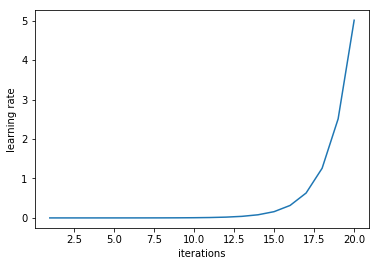

In [5]:
learn.sched.plot_lr()

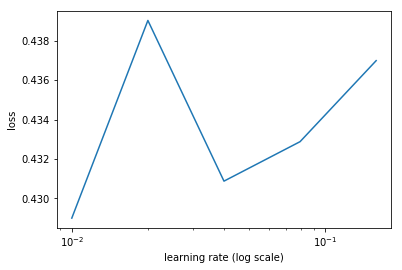

In [6]:
learn.sched.plot()

In [7]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.2)

In [8]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name="test")
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [9]:
best_lr = 1e-2
learn.fit(best_lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch:   0, train_loss: 0.656861, val_loss: 0.471669, accuracy: 0.716146
epoch:   1, train_loss: 0.570435, val_loss: 0.426045, accuracy: 0.791667



In [10]:
learn.precompute=False

In [11]:
learn.fit(best_lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.540554, val_loss: 0.403095, accuracy: 0.822917
epoch:   1, train_loss: 0.519897, val_loss: 0.410389, accuracy: 0.794271
epoch:   2, train_loss: 0.505138, val_loss: 0.396184, accuracy: 0.812500



In [12]:
learn.save('224_lastlayer')
learn.load('224_lastlayer')

In [13]:
learn.unfreeze()

In [14]:
lr=np.array([best_lr/9,best_lr/3,best_lr])

In [19]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.337420, val_loss: 0.359157, accuracy: 0.820312
epoch:   1, train_loss: 0.329723, val_loss: 0.315181, accuracy: 0.875000
epoch:   2, train_loss: 0.320380, val_loss: 0.323570, accuracy: 0.869792
epoch:   3, train_loss: 0.326823, val_loss: 0.379417, accuracy: 0.799479
epoch:   4, train_loss: 0.317182, val_loss: 0.347575, accuracy: 0.859375
epoch:   5, train_loss: 0.304938, val_loss: 0.371317, accuracy: 0.835938
epoch:   6, train_loss: 0.287670, val_loss: 0.371084, accuracy: 0.830729



In [20]:
learn.save('224_all')
learn.load('224_all')

In [21]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy(probs, y)

0.8580246913580247

In [87]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
ds = pd.DataFrame(probs[:,1])
ds.columns = ['is_iceberg']
# ds.columns = data.classes

In [ ]:
ds.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
ds.head()

In [85]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
ds.to_csv(f'{SUBM}subm.csv', index=False)

In [86]:
FileLink(f'{SUBM}subm.csv')

/home/chiay/fastai/courses/dl1/data/iceberg3/subm/subm.csv

In [82]:
ds.shape

(8424, 2)

In [88]:
import sklearn

In [92]:
sklearn.metrics.log_loss(y, probs)

ValueError: y_true contains only one label (0.0). Please provide the true labels explicitly through the labels argument.

In [93]:
probs.shape

(8424, 2)

In [94]:
y.shape

(8424, 1)